In [3]:
import cv2
import os
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import loguniform
from skimage.feature import hog
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split , RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
PATH = '/content/data'
WIDTH = 224
HEIGHT = 224

In [6]:
PATH = os.path.join('/content/data', 'faces')

In [7]:
os.makedirs(PATH, exist_ok=True)

In [8]:
!unzip -q /content/drive/MyDrive/faces.zip -d /content/data/faces

In [9]:
PATHH = '/content/data/faces/content/data'

In [10]:
images = []
labels = []

In [11]:
for label in ['negative', 'positive', 'anchor']:
    folder = os.path.join(PATHH, label, 'face')
    count = 0
    for filename in os.listdir(folder):
      if (label in ['anchor', 'positive'] and count == 500) or (label == 'negative' and count == 1000):
        break

      image_path = os.path.join(folder, filename)
      image = cv2.imread(image_path)
      image = cv2.resize(image, (WIDTH, HEIGHT))
      images.append(image)

      if label == 'anchor':
        labels.append('positive')
        count += 1
        continue

      labels.append(label)
      count += 1

print(len(images))

2000


In [12]:
print(set(labels))

{'positive', 'negative'}


In [13]:
indexes = [random.randint(0, len(images) - 1) for _ in range(9)]
indexes

[1153, 1586, 181, 1713, 1661, 1453, 1402, 1669, 782]

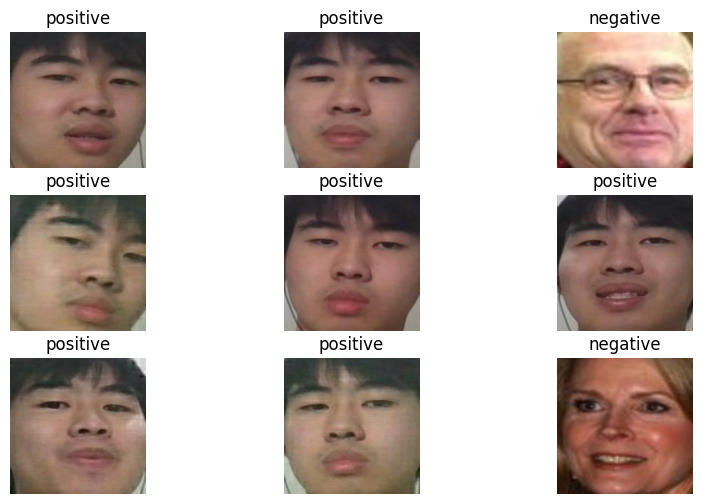

In [14]:
fig = plt.figure(figsize=(10, 6))
for i in range(1, 10):
    index = indexes[i-1]
    plt.subplot(3, 3, i)
    plt.imshow(cv2.cvtColor(images[index], cv2.COLOR_BGR2RGB))
    plt.title(labels[index])
    plt.axis('off')

plt.show()

In [15]:
le = LabelEncoder()
Labels= le.fit_transform(labels)

In [16]:
images_gray = [cv2.cvtColor(images[i] , cv2.COLOR_BGR2GRAY) for i in range(len(images))]

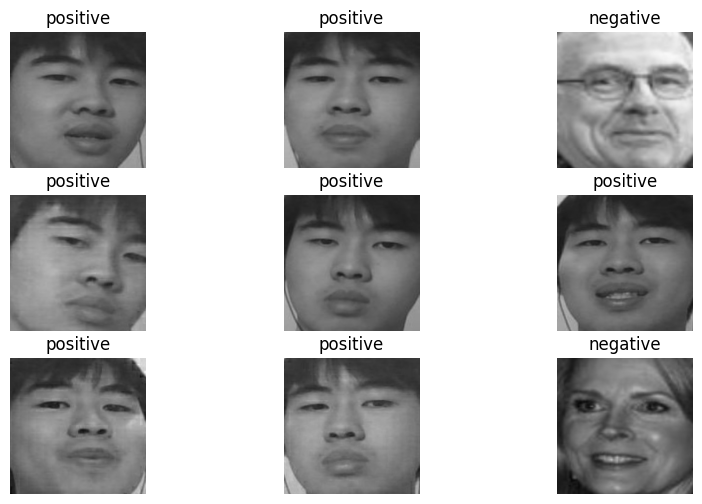

In [17]:
fig = plt.figure(figsize=(10, 6))
for i in range(1, 10):
    index = indexes[i-1]
    plt.subplot(3, 3, i)
    plt.imshow(cv2.cvtColor(images_gray[index], cv2.COLOR_BGR2RGB))
    plt.title(labels[index])
    plt.axis('off')

plt.show()

In [18]:
Labels = np.array(Labels).reshape(len(Labels),1)

In [19]:
hog_features = []
hog_images = []
for image in tqdm(images_gray):
    fd , hogim = hog(image , orientations=9 , pixels_per_cell=(8, 8) , block_norm='L2' , cells_per_block=(4, 4) , visualize=True)
    hog_images.append(hogim)
    hog_features.append(fd)

100%|██████████| 2000/2000 [06:00<00:00,  5.54it/s]


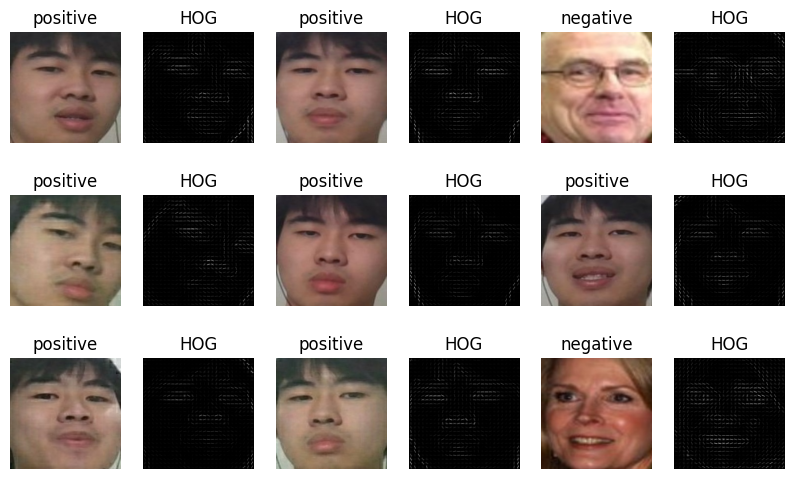

In [20]:
fig = plt.figure(figsize=(10, 6))
for i in range(1, 10):
    index = indexes[i-1]

    # Original image
    plt.subplot(3, 6, 2 * i - 1)
    plt.imshow(cv2.cvtColor(images[index], cv2.COLOR_BGR2RGB))
    plt.title(labels[index])
    plt.axis('off')

    # HOG
    hog_im_normalized = cv2.normalize(hog_images[index], None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    plt.subplot(3, 6, 2 * i)
    plt.imshow(hog_im_normalized, cmap="gray")
    plt.title("HOG")
    plt.axis('off')

plt.show()


In [21]:
hog_features = np.array(hog_features)
df = np.hstack((hog_features,Labels))

In [22]:
df = shuffle(df, random_state=42)

In [23]:
X = df[:,:-1]
Y = df[:,-1]

In [24]:
X_train , X_test , Y_train , Y_test = train_test_split(X, Y, test_size=0.3 ,random_state=42)

In [25]:
pca = PCA().fit(X_train)

In [26]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [36]:
model = SVC(kernel='rbf', class_weight='balanced')
model.fit(X_train_pca, Y_train);

In [37]:
y_pred = model.predict(X_test_pca)

accuracy = accuracy_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred)
recall = recall_score(Y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.8900
Precision: 0.8231
Recall: 1.0000
